# Tau to Muon Decay - Finding New Physics

> ### Description : The aim of this notebook is to find a phenomenon that is not already known to exist – charged lepton flavour violation – thereby helping to establish "new physics". 

# Problem Statement: From a list of collision events and their properties, predict whether a τ → 3μ decay happened in this collision. This τ → 3μ is currently assumed by scientists not to happen, and the goal of this competition is to discover τ → 3μ happening more frequently than scientists currently can understand.

## Data : https://www.kaggle.com/competitions/flavours-of-physics-kernels-only/data

# Imports and File Reads

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flavours-of-physics-kernels-only/check_correlation.csv.zip
/kaggle/input/flavours-of-physics-kernels-only/sample_submission.csv.zip
/kaggle/input/flavours-of-physics-kernels-only/training.csv.zip
/kaggle/input/flavours-of-physics-kernels-only/check_agreement.csv.zip
/kaggle/input/flavours-of-physics-kernels-only/test.csv.zip


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import math
import dateutil.parser
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score, confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score, auc, precision_recall_curve, precision_score, recall_score

In [3]:
import xgboost as xgb

In [4]:
np.set_printoptions(linewidth=140)
pd.set_option('display.width', 140)

# Read in the data

In [5]:
path = '/kaggle/input/flavours-of-physics-kernels-only/'

train = pd.read_csv(path+'training.csv.zip', index_col='id')
test  = pd.read_csv(path+'test.csv.zip', index_col = "id")

In [6]:
train.head(3)

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
id,,,,,,,,,,,,,,,,,,,,,
18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630


In [7]:
train.shape, test.shape

((67553, 50), (855819, 46))

#### Nothing is null, that's good

In [8]:
train.isna().sum()

LifeTime               0
dira                   0
FlightDistance         0
FlightDistanceError    0
IP                     0
IPSig                  0
VertexChi2             0
pt                     0
DOCAone                0
DOCAtwo                0
DOCAthree              0
IP_p0p2                0
IP_p1p2                0
isolationa             0
isolationb             0
isolationc             0
isolationd             0
isolatione             0
isolationf             0
iso                    0
CDF1                   0
CDF2                   0
CDF3                   0
ISO_SumBDT             0
p0_IsoBDT              0
p1_IsoBDT              0
p2_IsoBDT              0
p0_track_Chi2Dof       0
p1_track_Chi2Dof       0
p2_track_Chi2Dof       0
p0_IP                  0
p1_IP                  0
p2_IP                  0
p0_IPSig               0
p1_IPSig               0
p2_IPSig               0
p0_pt                  0
p1_pt                  0
p2_pt                  0
p0_p                   0


#### There are a few variables such as SPDhits and p0IPSig that have larger numerical values than the others.

In [9]:
train.describe()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
count,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,6.755300e+04,6.755300e+04,...,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000
mean,0.001255,0.999846,15.153986,0.501794,0.090363,5.305426,5.132504,5027.967460,4.496067e-02,3.760934e-02,...,33050.376570,24407.169131,3.280283,3.197816,3.233437,269.119832,-36.657765,0.616908,1779.389403,0.488508
std,0.000779,0.000540,15.060723,0.426345,0.085216,4.331420,3.849261,3010.766079,6.052672e-02,4.129047e-02,...,30190.555855,25076.484396,0.592017,0.592466,0.588628,127.446169,49.145483,0.486144,66.956336,0.238141
min,0.000144,0.990090,0.804510,0.075224,0.000264,0.020823,0.001895,314.100067,9.142349e-08,2.434845e-08,...,3052.763672,3008.329102,1.638945,1.673761,1.746441,5.000000,-99.000000,0.000000,1480.453491,0.000177
25%,0.000725,0.999916,6.225103,0.236352,0.027773,1.830687,1.995162,3157.041748,1.298088e-02,1.131008e-02,...,14357.550781,9325.879883,2.848309,2.746091,2.792214,171.000000,-99.000000,0.000000,1766.956787,0.277863
50%,0.001061,0.999985,10.604475,0.366318,0.058136,3.628297,4.116704,4366.348145,2.912052e-02,2.549105e-02,...,23996.681641,16510.722656,3.249017,3.166046,3.205477,254.000000,1.000000,1.000000,1777.976562,0.455296
75%,0.001559,0.999997,18.554255,0.598817,0.134010,8.221298,7.598480,6079.195801,5.754587e-02,4.908246e-02,...,40976.976562,30108.750000,3.688323,3.623785,3.647688,354.000000,1.000000,1.000000,1789.937622,0.695368
max,0.022134,1.000000,449.242554,5.878616,2.245918,24.074131,14.998641,74390.289062,8.312201e+00,8.892956e-01,...,602064.750000,461608.593750,5.164036,5.090231,5.124544,632.000000,10.000000,1.000000,1949.984009,0.985871


## 'production', 'mass', 'min_ANNmuon' aren't in the test, so they have to be removed


In [10]:

all_num_cols = ['LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP', 'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc', 'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2',
       'CDF3', 'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP',
       'p1_IP', 'p2_IP', 'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p', 'p1_p', 'p2_p', 'p0_eta', 'p1_eta',
       'p2_eta', 'SPDhits']

In [11]:
y = train["signal"]
x = train[all_num_cols] 

# Scale the data, so everyone is speaking the same numerical precision

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled= pd.DataFrame(sc.fit_transform(x), columns=all_num_cols)
X_scaled.var()

LifeTime               1.000015
dira                   1.000015
FlightDistance         1.000015
FlightDistanceError    1.000015
IP                     1.000015
IPSig                  1.000015
VertexChi2             1.000015
pt                     1.000015
DOCAone                1.000015
DOCAtwo                1.000015
DOCAthree              1.000015
IP_p0p2                1.000015
IP_p1p2                1.000015
isolationa             1.000015
isolationb             1.000015
isolationc             1.000015
isolationd             1.000015
isolatione             1.000015
isolationf             1.000015
iso                    1.000015
CDF1                   1.000015
CDF2                   1.000015
CDF3                   1.000015
ISO_SumBDT             1.000015
p0_IsoBDT              1.000015
p1_IsoBDT              1.000015
p2_IsoBDT              1.000015
p0_track_Chi2Dof       1.000015
p1_track_Chi2Dof       1.000015
p2_track_Chi2Dof       1.000015
p0_IP                  1.000015
p1_IP   

In [13]:
X_scaled.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
0,0.415529,0.283944,-0.074409,0.421273,-0.872181,-1.120551,-0.839666,-1.177759,0.358619,0.556846,...,-0.891851,-1.166085,-0.252180,-0.808179,-0.687625,0.592481,-0.345054,1.360399,1.355836,1.482050
1,-0.342113,-0.261629,-0.638608,-0.467825,0.607873,0.983305,-1.108491,-0.656730,-0.345945,-0.444765,...,-0.526101,-0.223803,-0.687607,-0.501196,-0.546125,-0.680559,-0.087379,-0.694178,-0.438094,1.074031
2,-0.485059,0.255793,-0.600021,-0.528523,-0.652664,-0.769886,1.518055,-0.376006,0.166591,0.250368,...,-0.523686,0.098579,-0.541693,-0.292941,-0.342990,-0.565548,0.433471,-0.560594,-0.306864,-0.573735
3,-0.513937,0.105325,-0.659065,-0.659225,-0.163987,-0.238744,-0.482212,-0.337852,0.145702,-0.755444,...,-0.054039,-0.629221,-0.055558,-0.280617,-0.534637,-0.608772,-0.325705,0.034125,-1.457376,-1.036679
4,-0.160761,0.276437,1.587953,3.275310,0.358768,-0.073982,-1.211711,-0.293423,-0.668629,-0.006868,...,0.423617,-0.389092,-0.326862,4.031841,2.138513,0.905700,2.283754,2.554325,1.806658,1.631133


# Train Validation Split

#### The test data that's supplied doesn't contain a signal column, so it can't be used for testing the robustness of the model. It will be used only for making the predictions at the end. So, split the train into train and validation sets and the latter would be used as the "test" set.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25, random_state=42)


In [15]:
train.shape, x.shape, X_train.shape, X_val.shape

((67553, 50), (67553, 46), (50664, 46), (16889, 46))

## Fit a model without any adjustments to check what variables are important

In [16]:
print("Random Forest")
rf = RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train, y_train)

Random Forest


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [17]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [18]:
fi = rf_feat_importance(rf, X_train)
fi.sort_values("imp", ascending = False)[:10]

,cols,imp
5,IPSig,0.121363
4,IP,0.094929
1,dira,0.077996
45,SPDhits,0.052077
27,p0_track_Chi2Dof,0.039788
6,VertexChi2,0.039060
23,ISO_SumBDT,0.037675
19,iso,0.026700
24,p0_IsoBDT,0.026252
0,LifeTime,0.026069


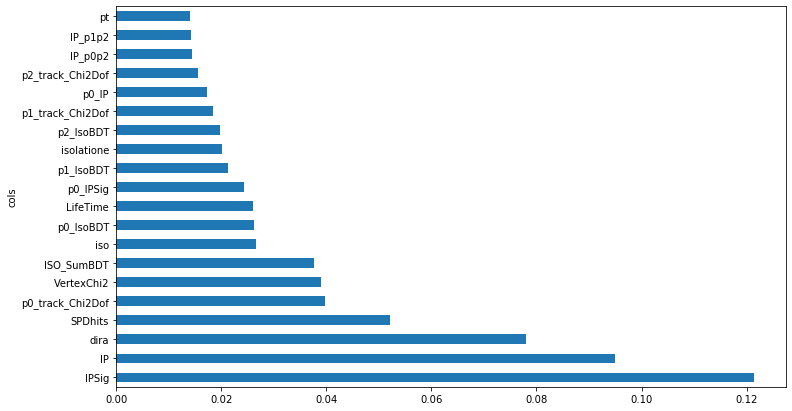

In [19]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:20]);


## Use the selected columns to create a slice of the training data

In [20]:
selected_cols = ["IPSig", "IP", "dira", "SPDhits", "VertexChi2", "p0_track_Chi2Dof", "ISO_SumBDT", "iso", "LifeTime", "p0_IsoBDT", "p0_IPSig", "isolatione" ]

In [21]:
X_train = X_train[selected_cols] 

In [22]:
X_train.shape

(50664, 12)

### Not ideal profiles but that's expected in the experiments. Hopefully, Random Forests and Boosting algos will take care of them

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70a83472d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7095bbe750>]], dtype=object)

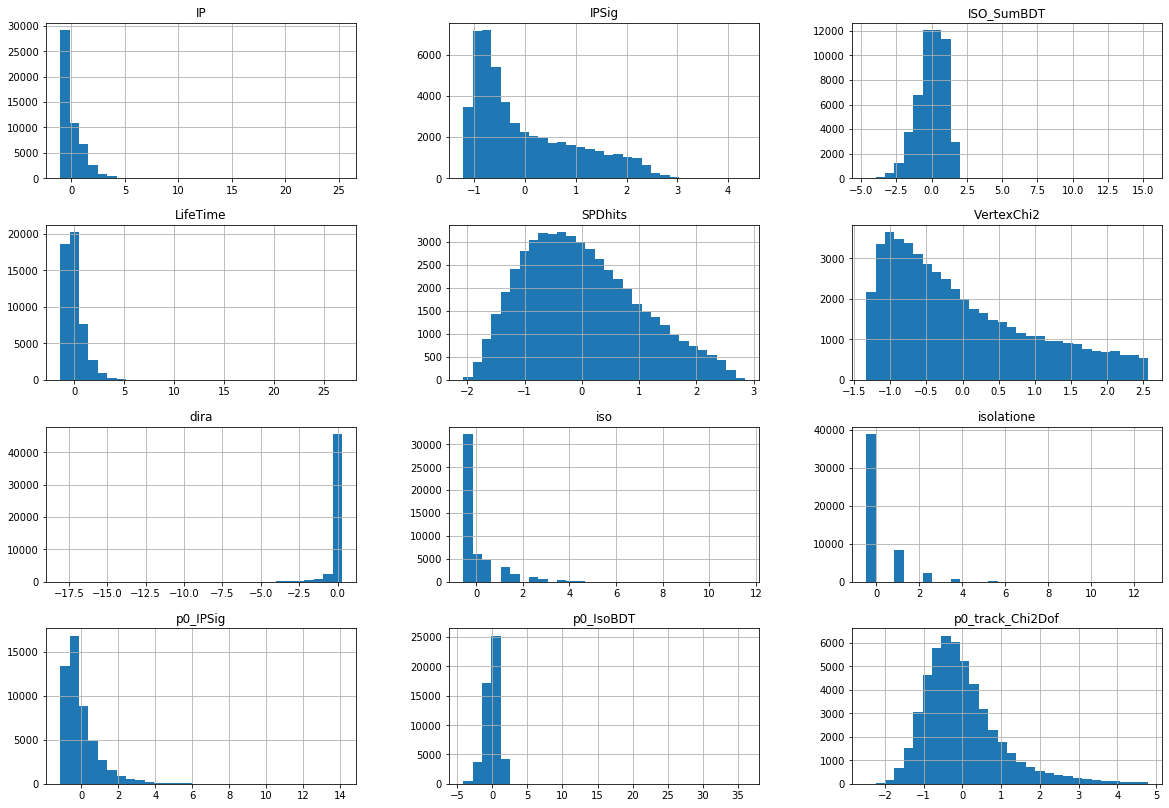

In [23]:
X_train.hist(bins=30, figsize=(20, 14))


#### Good that data isn't just only signal or only background. 3:2 ratio seems ok!

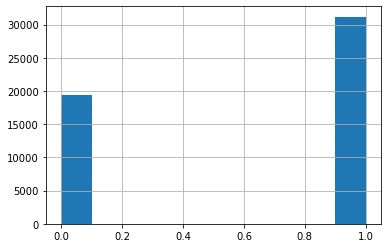

In [24]:
y_train.hist()

####  Don't run these, they actually made things worse

In [ ]:
# transformations
X_train['SPDhits'] = np.log(X_train['SPDhits'])
X_train['p0_IPSig'] = np.log(X_train['p0_IPSig'])

In [ ]:
X_train["SPDhits"].hist(bins=30, figsize=(5, 3))


In [ ]:
X_train["p0_IPSig"].hist(bins=30, figsize=(5, 3))


#### Don't run ends

# Correlation Matrix for the variables selected. Some strong correlations owe their values to the method of production

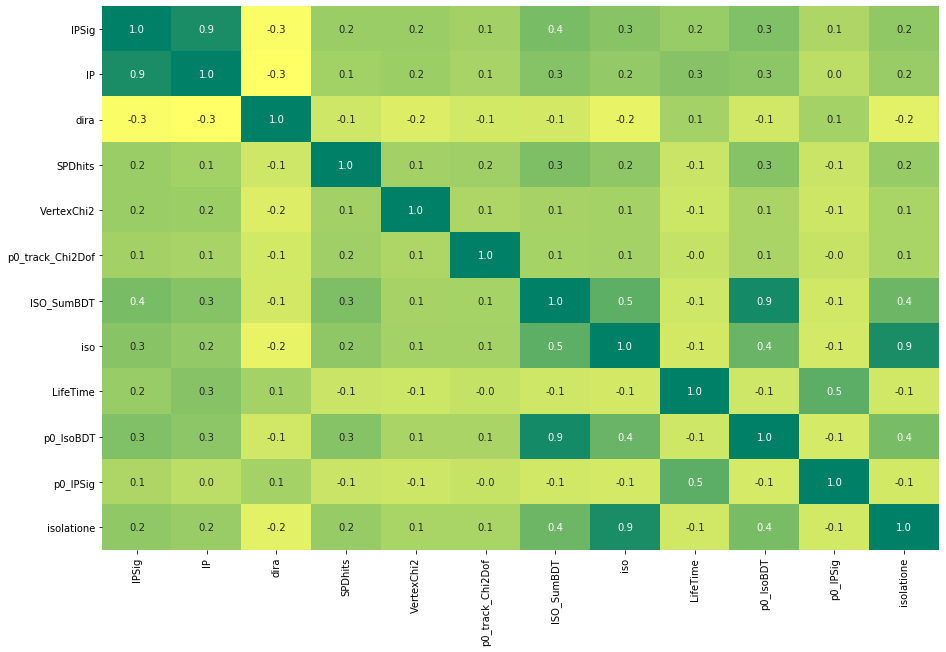

In [25]:
plt.figure(figsize=(15,10))
sns.heatmap(X_train.corr(), annot=True, cbar=False, fmt='.1f', cmap='summer_r')
plt.show()

# Helper Functions

### Root mean squared error

In [90]:
def r_mse(pred,y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

### Confusion matrix

In [101]:
def con_matrix(y_val, val_preds_bin):
    matrix = confusion_matrix(y_val, val_preds_bin)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(8,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = ['Signal', 'Background']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Ensemble Model')
    plt.show()
    

### Metrics

In [106]:
def metric_report(y_val, pred_val):
    print("Accuracy Random_Forest:", accuracy_score(y_val, pred_val))
    print("Precision Random_Forest:", precision_score(y_val, pred_val))
    print("Recall Random_Forest:", recall_score(y_val, pred_val))
    print("F1 Score Random_Forest:", f1_score(y_val, pred_val))

    

### ROC Curve

In [ ]:
def roc_curvePlot(y_val, val_preds):
    
    fpr, tpr, threshold = metrics.roc_curve(y_val, val_preds)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.style.use('default')
    plt.title('ROC curve')
    plt.plot(tpr, 1-fpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [1, 0],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('Signal efficiency (TPR)')
    plt.ylabel('Background rejection (1-FPR)')
    plt.show()


# Models

## Decision Tree

In [28]:
m = DecisionTreeRegressor()
m.fit(X_train, y_train);

In [30]:
X_val = X_val[selected_cols]
X_val.shape

(16889, 12)

In [31]:
pred_val = m.predict(X_val)

In [32]:
y_val.shape, pred_val.shape

((16889,), (16889,))

In [33]:
r_mse(pred_val, y_val)

0.450787

## Random Forests

In [39]:
# A rf classifier again
print("Random Forest")
trees = [10, 50, 100, 150, 200,250, 300,350, 400,450, 500, 550, 600, 650]
err = []
tm = []
for t in trees:
    start = time.time()
    print("Preparing trees: ", t)
    rf = RandomForestClassifier(n_estimators=t, random_state=11)
    rf.fit(X_train, y_train)
    pred_val_rf = rf.predict(X_val)
    err.append(r_mse(pred_val_rf, y_val))
    end = time.time()
    tm.append(end-start)
    print(f" For Tree with depth {i}, it took {end - start} second")

Random Forest
Preparing trees:  10
 For Tree with depth 9, it took 1.905045986175537 second
Preparing trees:  50
 For Tree with depth 9, it took 9.269953727722168 second
Preparing trees:  100
 For Tree with depth 9, it took 18.74191951751709 second
Preparing trees:  150
 For Tree with depth 9, it took 27.8441321849823 second
Preparing trees:  200
 For Tree with depth 9, it took 37.205913066864014 second
Preparing trees:  250
 For Tree with depth 9, it took 46.68583273887634 second
Preparing trees:  300
 For Tree with depth 9, it took 55.99767518043518 second
Preparing trees:  350
 For Tree with depth 9, it took 65.16085720062256 second
Preparing trees:  400
 For Tree with depth 9, it took 74.60902190208435 second
Preparing trees:  450
 For Tree with depth 9, it took 83.86420130729675 second
Preparing trees:  500
 For Tree with depth 9, it took 93.22141027450562 second
Preparing trees:  550
 For Tree with depth 9, it took 104.05555772781372 second
Preparing trees:  600
 For Tree with de

#### Adding trees after a while doesn't help!

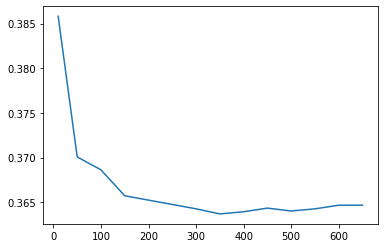

In [41]:
plt.plot(trees, err)

#### Time increases linearly, I was expecting exponential

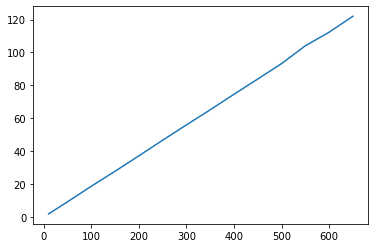

In [42]:
plt.plot(trees, tm)

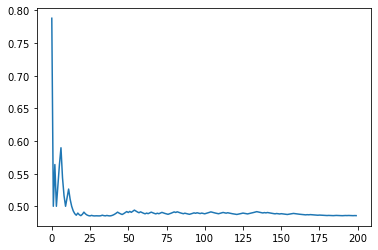

In [45]:
plt.plot([r_mse(pred_val[:i+1].mean(0), y_val) for i in range(200)]);


#### Decent scores

In [104]:
metric_report(y_val, pred_val_rf)

Accuracy Random_Forest: 0.8670140328024157
Precision Random_Forest: 0.8891304347826087
Recall Random_Forest: 0.8976145038167939
F1 Score Random_Forest: 0.89335232668566


In [49]:
confusion_matrix(y_val, pred_val_rf)


array([[5236, 1173],
       [1073, 9407]])

### Confusion matrix

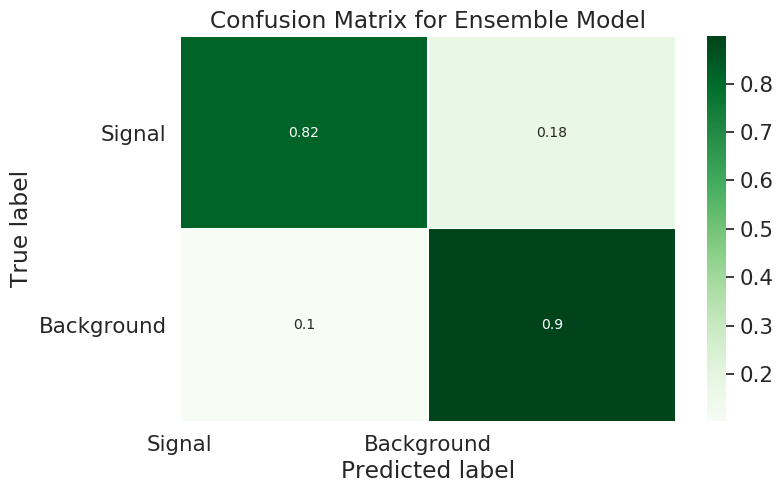

In [102]:
con_matrix(y_val, pred_val_rf)

## Xgboost

In [55]:
print("XGBoost")
params = {"objective": "binary:logistic",
          "base_Score": 0.5,
          "eta": 0.3,
          "max_depth": 5,
          "min_child_weight": 3,
          "silent": 1,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "seed": 1}
num_trees=200

XGBoost


In [56]:
gbm = xgb.train(params, xgb.DMatrix(X_train, y_train), num_trees)

In [57]:
pred_gbm = gbm.predict(xgb.DMatrix(X_val))

In [58]:
r_mse(pred_gbm, y_val)

0.314701

### Xgboost doesn't push the values to floor or ceiling, so we'll have to do it explicitly for the accuracy score and other metrics

In [59]:
pred_gbm

array([0.05536356, 0.97199875, 0.02173601, ..., 0.9915537 , 0.96224195, 0.87197673], dtype=float32)

In [60]:
pred_gbm_bin =[]
for val in pred_gbm:
    if val > 0.5:
        pred_gbm_bin.append(1)
    else:
        pred_gbm_bin.append(0)
   


In [107]:
metric_report(y_val, pred_gbm_bin)

Accuracy Random_Forest: 0.8636982651429925
Precision Random_Forest: 0.884015777610819
Recall Random_Forest: 0.8981870229007634
F1 Score Random_Forest: 0.8910450586898903


In [62]:
confusion_matrix(y_val, pred_gbm_bin)


array([[5174, 1235],
       [1067, 9413]])

## These models are not performing amazingly well! MSE is quite high but still classification seems not too bad. Out of ~16k, 14k seem to be correctly classified.

## Just for the sake of it, what does old Logistic Regression says?

In [91]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_lr = clf.predict(X_val)


In [108]:
metric_report(y_val, pred_lr)

Accuracy Random_Forest: 0.8433891882290248
Precision Random_Forest: 0.8570777504329596
Recall Random_Forest: 0.8972328244274809
F1 Score Random_Forest: 0.8766957251410191


### Hmmm...slightly worse.

# Ensemble

In [94]:
val_preds = (pred_lr + pred_gbm_bin + pred_val_rf)/3

In [95]:
val_rmse = r_mse(val_preds , y_val)
val_rmse

0.340731

In [96]:
np.unique(val_preds)

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [97]:
val_preds_bin =[]
for val in val_preds:
    if val >= 0.5:
        val_preds_bin.append(1)
    else:
        val_preds_bin.append(0)
   


In [109]:
metric_report(y_val, val_preds_bin)

Accuracy Random_Forest: 0.8658890402036828
Precision Random_Forest: 0.8852828064909484
Recall Random_Forest: 0.9005725190839695
F1 Score Random_Forest: 0.8928622108698737


## Classification report

In [110]:
target_names = ['signal', 'Background']
print(classification_report(y_val, val_preds_bin, target_names=target_names))


              precision    recall  f1-score   support

      signal       0.83      0.81      0.82      6409
  Background       0.89      0.90      0.89     10480

    accuracy                           0.87     16889
   macro avg       0.86      0.85      0.86     16889
weighted avg       0.87      0.87      0.87     16889



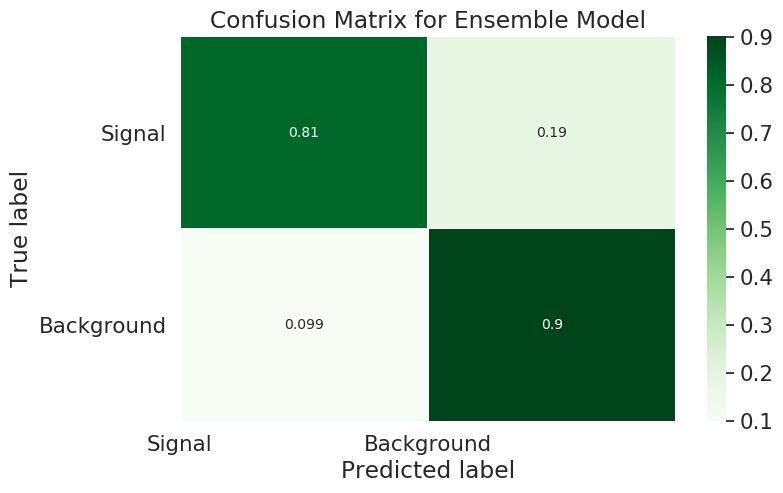

In [100]:
con_matrix(y_val, val_preds_bin)

## ROC Curve

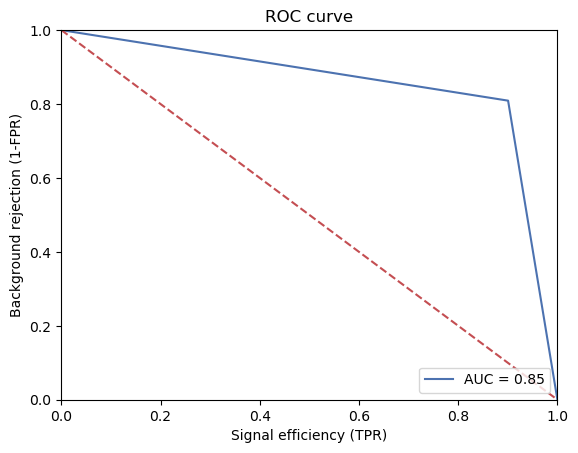

In [112]:
roc_curvePlot(y_val, val_preds_bin)

# Final predictions for the test set

### Here, just taking the Xgboost's results

In [79]:
X_test = test[selected_cols]
cols = X_test.columns
X_scaled_test = pd.DataFrame(sc.fit_transform(X_test), columns=cols)

In [81]:
test_probs = xgb.predict(X_scaled_test)

In [82]:
test_probs

array([0, 0, 1, ..., 0, 1, 1])

In [83]:
np.unique(test_probs)

array([0, 1])

# Submit to Kaggle

In [85]:
test.shape

(855819, 46)

In [86]:
p  = pd.read_csv(path+'test.csv.zip')

In [87]:
df_submit = pd.DataFrame()
df_submit["id"] = p["id"] 
df_submit["prediction"] = test_probs

In [88]:
df_submit.to_csv('submission.csv', index=False, sep=',')


# End of Notebook